Task 1 – Image Acquisition

In [1]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread("image.jpg")  


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image")
plt.show()


ModuleNotFoundError: No module named 'cv2'

Task 2 – Noise Simulation

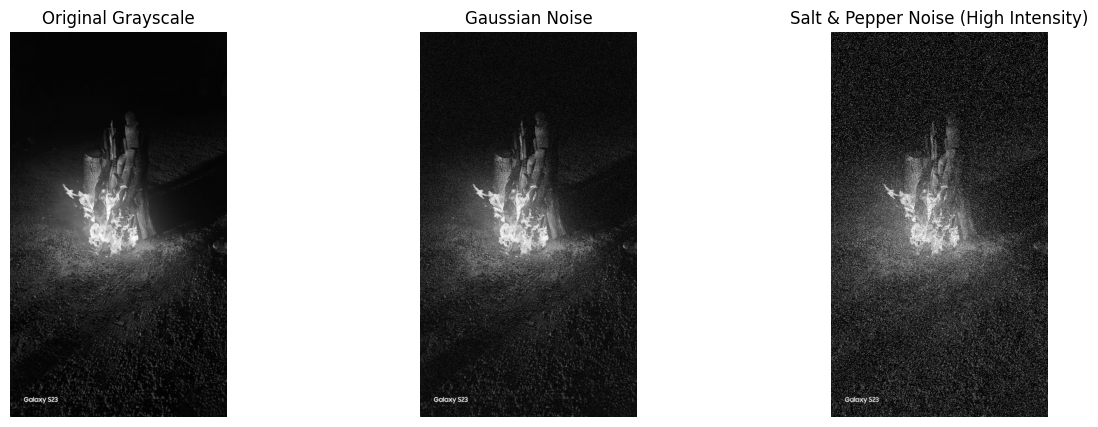

In [24]:
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise


img = cv2.imread("image.jpg")   


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


gaussian_noisy = (random_noise(gray, mode="gaussian", var=0.01) * 255).astype("uint8")
sp_noisy = (random_noise(gray, mode="s&p", amount=0.15) * 255).astype("uint8")


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original Grayscale", "Gaussian Noise", "Salt & Pepper Noise (High Intensity)"]
images = [gray, gaussian_noisy, sp_noisy]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()


Task 3 – Preprocessing & Enhancement

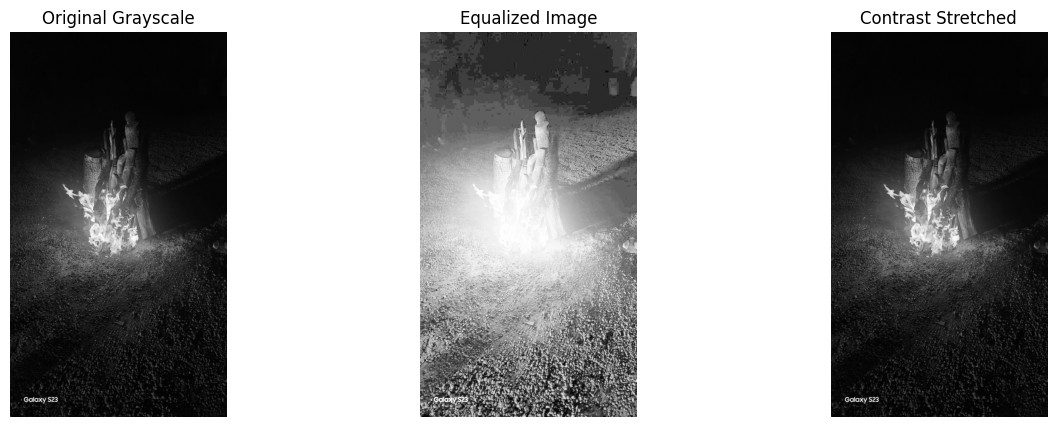

In [25]:
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise
import numpy as np   # ✅ Add this line


def manual_histogram_equalization(img):
    h, w = img.shape
    hist = np.zeros(256, dtype=int)

    for y in range(h):
        for x in range(w):
            hist[img[y, x]] += 1

    cdf = hist.cumsum()
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    mapping = np.round(cdf_normalized).astype("uint8")

    equalized_img = np.zeros_like(img)
    for y in range(h):
        for x in range(w):
            equalized_img[y, x] = mapping[img[y, x]]

    return equalized_img


img = cv2.imread("image.jpg")   
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gaussian_noisy = (random_noise(gray, mode="gaussian", var=0.01) * 255).astype("uint8")
sp_noisy = (random_noise(gray, mode="s&p", amount=0.15) * 255).astype("uint8")

# Histogram Equalization on grayscale image
equalized = manual_histogram_equalization(gray)

# Contrast Stretching
min_val, max_val = gray.min(), gray.max()
contrast_stretched = ((gray - min_val) / (max_val - min_val) * 255).astype("uint8")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original Grayscale", "Equalized Image", "Contrast Stretched"]
images = [gray, equalized, contrast_stretched]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()


Task 4 – Noise Filtering & Denoising

Gaussian Noise Filtering:
PSNR: 13.9649
SSIM: 0.0661

Salt & Pepper Noise Filtering:
PSNR: 13.9649
SSIM: 0.0637


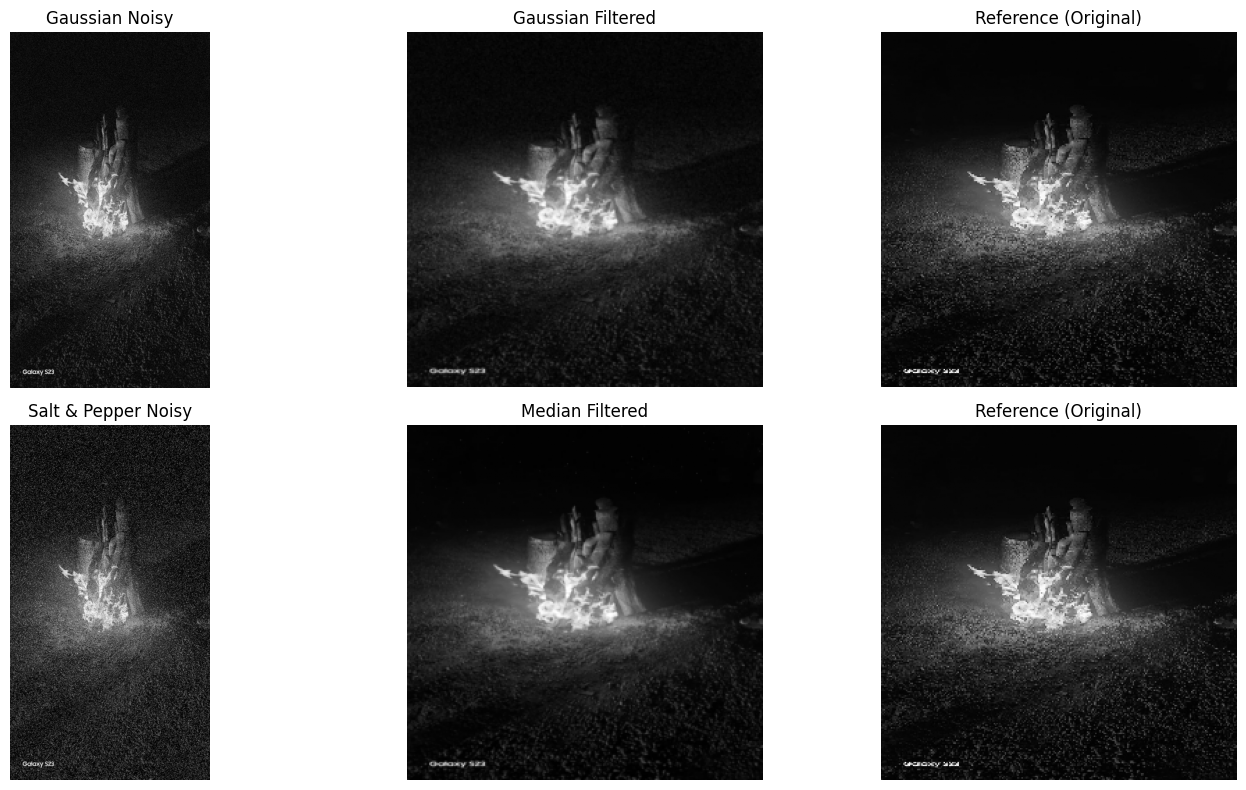

In [26]:
from scipy.ndimage import gaussian_filter, median_filter
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

# Assuming these come from your previous steps:
# resized, gaussian_noisy, sp_noisy

# Apply filters
gauss_filtered = gaussian_filter(gaussian_noisy, sigma=1)
median_filtered = median_filter(sp_noisy, size=3)

# 🔧 Ensure filtered images match the reference size
gauss_filtered = resize(gauss_filtered, resized.shape, anti_aliasing=True)
median_filtered = resize(median_filtered, resized.shape, anti_aliasing=True)

# Convert to float for metric calculation
resized = resized.astype(np.float32)
gauss_filtered = gauss_filtered.astype(np.float32)
median_filtered = median_filtered.astype(np.float32)

# ✅ Define data_range explicitly for float images
data_range = resized.max() - resized.min()  # typically 255 for 8-bit images

# PSNR & SSIM
print("Gaussian Noise Filtering:")
print(f"PSNR: {psnr(resized, gauss_filtered, data_range=data_range):.4f}")
print(f"SSIM: {ssim(resized, gauss_filtered, data_range=data_range):.4f}\n")

print("Salt & Pepper Noise Filtering:")
print(f"PSNR: {psnr(resized, median_filtered, data_range=data_range):.4f}")
print(f"SSIM: {ssim(resized, median_filtered, data_range=data_range):.4f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0,0].imshow(gaussian_noisy, cmap="gray")
axes[0,0].set_title("Gaussian Noisy")
axes[0,0].axis("off")

axes[0,1].imshow(gauss_filtered, cmap="gray")
axes[0,1].set_title("Gaussian Filtered")
axes[0,1].axis("off")

axes[0,2].imshow(resized, cmap="gray")
axes[0,2].set_title("Reference (Original)")
axes[0,2].axis("off")

axes[1,0].imshow(sp_noisy, cmap="gray")
axes[1,0].set_title("Salt & Pepper Noisy")
axes[1,0].axis("off")

axes[1,1].imshow(median_filtered, cmap="gray")
axes[1,1].set_title("Median Filtered")
axes[1,1].axis("off")

axes[1,2].imshow(resized, cmap="gray")
axes[1,2].set_title("Reference (Original)")
axes[1,2].axis("off")

plt.tight_layout()
plt.show()


Alpha-Trimmed Filter -> PSNR: 29.8154, SSIM: 0.8161
Median Filter -> PSNR: 32.2348, SSIM: 0.9181


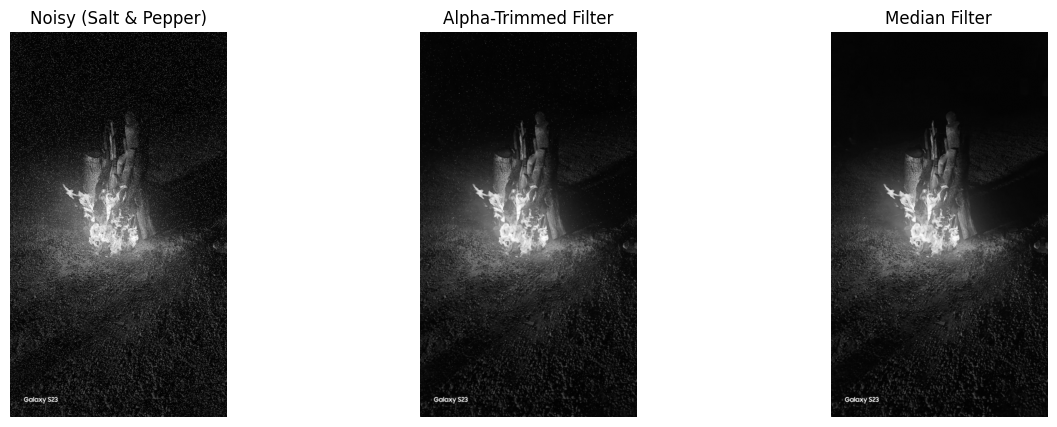

In [27]:
import numpy as np
from skimage.util import random_noise
from skimage.util.shape import view_as_windows
from scipy.ndimage import median_filter
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2


img = cv2.imread("image.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


sp_noisy = (random_noise(gray, mode='s&p', amount=0.05) * 255).astype(np.uint8)


def alpha_trimmed_mean_filter(image, ksize=3, d=2):
    pad = ksize // 2
    padded = np.pad(image, pad, mode="edge")
    windows = view_as_windows(padded, (ksize, ksize))
    out = np.zeros_like(image, dtype=np.float32)

    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            vals = np.sort(windows[i, j].ravel())
            trimmed = vals[d // 2 : len(vals) - d // 2]
            out[i, j] = np.mean(trimmed)

    return out.astype(np.uint8)


alpha_filtered = alpha_trimmed_mean_filter(sp_noisy, ksize=3, d=2)
median_filtered = median_filter(sp_noisy, size=3)


filters = [
    ("Alpha-Trimmed Filter", alpha_filtered),
    ("Median Filter", median_filtered)
]

for name, img_f in filters:
    print(f"{name} -> PSNR: {psnr(gray, img_f):.4f}, SSIM: {ssim(gray, img_f, data_range=img_f.max()-img_f.min()):.4f}")


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [sp_noisy, alpha_filtered, median_filtered]
titles = ["Noisy (Salt & Pepper)", "Alpha-Trimmed Filter", "Median Filter"]

for ax, im, title in zip(axes, images, titles):
    ax.imshow(im, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()






Task 5 – Segmentation & Object Isolation

In [28]:

_, thresh = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


edges = cv2.Canny(resized, 100, 200)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Resized Grayscale", "Otsu Thresholding", "Canny Edge Detection"]
images = [resized, thresh, edges]

for ax, im, title in zip(axes, images, titles):
    ax.imshow(im, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1633: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 5 (CV_32FC1)


Task 6 – Feature Evaluation

Object 1: Area = 0.00, Centroid = (0, 0)
Object 2: Area = 0.00, Centroid = (0, 0)
Object 3: Area = 0.00, Centroid = (0, 0)
Object 4: Area = 0.00, Centroid = (0, 0)
Object 5: Area = 0.00, Centroid = (0, 0)
Object 6: Area = 0.00, Centroid = (0, 0)
Object 7: Area = 0.00, Centroid = (0, 0)
Object 8: Area = 0.00, Centroid = (0, 0)
Object 9: Area = 0.00, Centroid = (0, 0)
Object 10: Area = 0.00, Centroid = (0, 0)
Object 11: Area = 0.00, Centroid = (0, 0)
Object 12: Area = 0.00, Centroid = (0, 0)
Object 13: Area = 0.00, Centroid = (0, 0)
Object 14: Area = 0.00, Centroid = (0, 0)
Object 15: Area = 0.00, Centroid = (0, 0)
Object 16: Area = 0.00, Centroid = (0, 0)
Object 17: Area = 9.00, Centroid = (52, 244)
Object 18: Area = 2.00, Centroid = (46, 244)
Object 19: Area = 32.00, Centroid = (27, 244)
Object 20: Area = 0.00, Centroid = (0, 0)
Object 21: Area = 0.00, Centroid = (0, 0)
Object 22: Area = 0.00, Centroid = (0, 0)
Object 23: Area = 0.00, Centroid = (0, 0)
Object 24: Area = 0.00, Centroid 

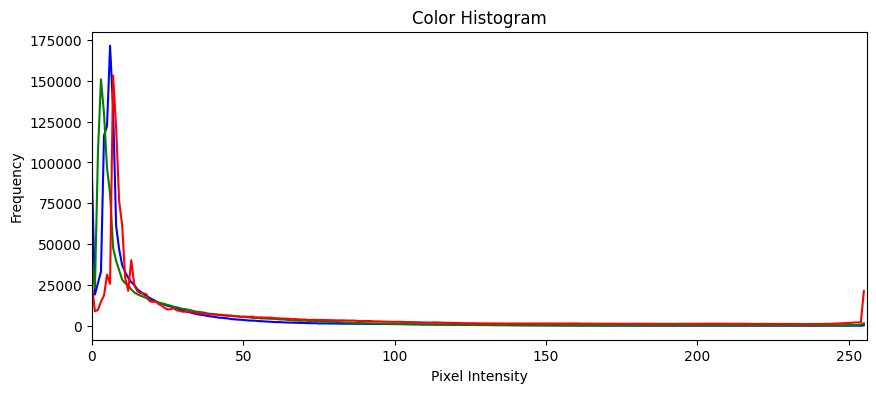

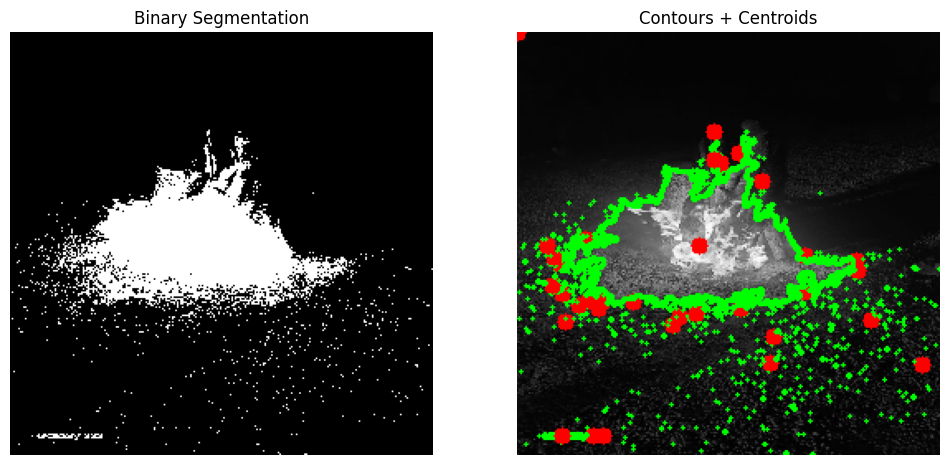

In [ ]:

binary = thresh.copy()


contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


contour_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)


for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)

    
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    
    cv2.drawContours(contour_img, [cnt], -1, (0,255,0), 2)
    cv2.circle(contour_img, (cx, cy), 5, (0, 0, 255), -1)

    
    print(f"Object {i+1}: Area = {area:.2f}, Centroid = ({cx}, {cy})")


color = ('b','g','r')
plt.figure(figsize=(10,4))
for i,col in enumerate(color):
    hist = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(hist, color=col)
    plt.xlim([0,256])
plt.title("Color Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(binary, cmap="gray")
plt.title("Binary Segmentation")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title("Contours + Centroids")
plt.axis("off")
plt.show()


Task 6 –  Result Visualization

Object 1: Area = 1437417.0, Centroid = (449, 799)


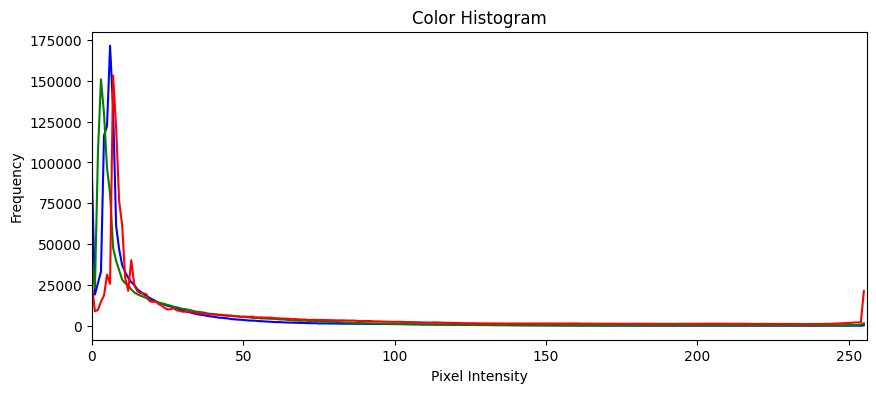

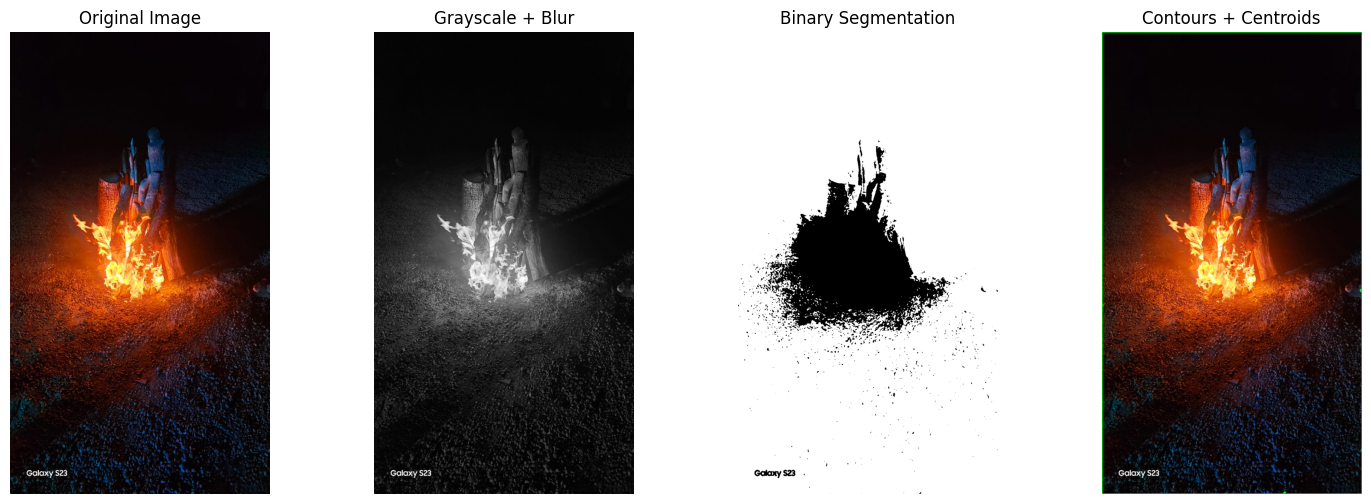

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = cv2.imread("image.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


blurred = cv2.GaussianBlur(gray, (5,5), 0)


_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)


features = []
for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
    else:
        cx, cy = 0, 0
    
    cv2.circle(contour_img, (cx, cy), 5, (0, 0, 255), -1)
    features.append((i+1, area, (cx, cy)))


for f in features:
    print(f"Object {f[0]}: Area = {f[1]}, Centroid = {f[2]}")


color = ('b','g','r')
plt.figure(figsize=(10,4))
for i,col in enumerate(color):
    hist = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(hist,color = col)
    plt.xlim([0,256])
plt.title("Color Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


fig, axes = plt.subplots(1,4, figsize=(18,6))
titles = ["Original Image", "Grayscale + Blur", "Binary Segmentation", "Contours + Centroids"]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB), gray, binary, cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)]

for ax, image, title in zip(axes, images, titles):
    if len(image.shape) == 2:  # grayscale
        ax.imshow(image, cmap="gray")
    else:
        ax.imshow(image)
    ax.set_title(title)
    ax.axis("off")

plt.show()
